# Find Average PAM/TAM Distance

This notebook is designed to find average PAM/TAM distance

# Info
Author: (Mo Qiqin)[https://mahhlab.org/team-members/]

Lab: (Ma Lab)[https://mahhlab.org/]

# Genome Data
We find PAMs in hg19, the genome file can be downloaded with the following command:
```
wget http://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/chromFa.tar.gz
```

unzip it with 
```
tar zxf chromFa.tar.gz
```


-----------------

# Codes:

In [1]:
import os
import re
import numpy as np
import pandas as pd
files = os.listdir()
import matplotlib.pyplot as plt
import collections
from tqdm.notebook import tqdm
from scipy import stats

-------------------
## Utils

In [2]:
def get_d_list(content,PAM):
    """Find PMA distance in sequence content
    Params:
        content: (str) sequence, for example: "AATTGGCCATGAGAG".
        PAM: (str) PAM pattern, a string writtern in regular expression. fro example: PAM=('([ATCG]GG)|CC[ATGC]')
        
    Return:
        distance_list: (list) A list contain a serias of distance. For example: [1,1,4,5,1,4],
        which means the distance of the first PAM and the 2nd PAM is 1; the distance of  2nd PAM and 3th
        is 1; the distance of 3th and 4th is 4....
        
    """
    # PAM=('([ATCG]GG)|CC[ATGC]')
    pam =re.finditer(PAM,content)
    # location = {}
    d = []
    index0 = 0

    for i in pam:
        index = i.start()
        match = i.group()
        distance = index - index0
        # location[index] = [distance,match]
        d.append(distance)
        index0 = index
    
    return d[1:]
    
 

In [3]:
def get_ds(PAM):
    """Search the PAM in each fa file.
    First, open a fa file and read the sequence as "ATCGATCGAAAAATTTCC" like str.
    Then, record the distances of every PAM location in each fa file.
    Last, combine all PAM distance list of each Chromasome into a list, then return it.
    
    Params:
        PAM: str, (str) PAM pattern, a string writtern in regular expression. fro example: PAM=('([ATCG]GG)|CC[ATGC]')
    
    Returns:
        distance_list_of_all_chr: list, A list contain a serias of distance. For example: [1,1,4,5,1,4]
    """
    ds = []
    files = tqdm(os.listdir())
    for i in files:
        if "fa" in i and not("_" in i):
            fa = i
            files.set_description(fa)
            with open(fa, 'r') as f:
                content = f.read().replace('\n','')
                d = get_d_list(content,PAM)
                ds = ds + d
    return ds

## PAM preparation

In [65]:
# Example 1
q = {'spCas9':'([ATCG]GG)|(CC[ATGC])',
    "saCas9":"([ATCG][ATCG]G[AG][AG]T)|(A[CT][CT]C[ATCG][[ATCG]])",
     "Cpf1":"(TTT[ACG])|([CGT]AAA)",
     "Un1Cas12f1":"(TTT[AG])|([TC]AAA)",
     "TnpB":"(TTGAT)|(ATCAA)",
     "IscB":"([ATCG][ATCG][AG][AG])|([CT][CT][ATCG][ATCG])"
    }

In [66]:
N = "[ATCG]"
V = "[ACG]"
V_ = "[TCG]"

R = "[AG]"
R_ = "[TC]"

Y = "[CT]"
Y_ ='[GA]'

M = "[AC]"
M_ = "[TG]"

A = 'A'
T = 'T'
C = 'C'
G = 'G'

In [67]:
N+N+N+V+R+Y+A+C

'[ATCG][ATCG][ATCG][ACG][AG][CT]AC'

In [68]:
# Example 2

pam_1 = N+N+N+V+R+Y+A+C
pam_1_ = (G+T+Y_+R_+V_+N+N+N)

pam_2 = (N+N+N+V+R+Y+M)
pam_2_ = (M_+Y_+R_+V_+N+N+N)


lsy = {"1":f"({pam_1})|({pam_1_})",
      "2":f"({pam_2})|({pam_2_})"}

In [52]:
lsy

{'1': '([ATCG][ATCG][ATCG][ACG][AG][CT]AC)|(GT[GA][TC][TCG][ATCG][ATCG][ATCG])',
 '2': '([ATCG][ATCG][ATCG][ACG][AG][CT][AC])|([TG][GA][TC][TCG][ATCG][ATCG][ATCG])'}

## Start counting

In [58]:
# code for example 2
fig_data = {}
output = ''
for cas in lsy:
    print(cas)
    PAM = lsy[cas]
    ds = get_ds(PAM)
    mode = stats.mode(ds)[0][0]
    count = len(ds)
    mean = sum(ds)/count
    output = output + (f"{cas} PAM距离的平均数是{mean:100},众数是{mode:100},hg19中一共有{count}个靶点") + "\n"
    print(f"{cas} PAM距离的平均数是{mean:100},众数是{mode:100},hg19中一共有{count}个靶点")
    s1 = pd.Series(ds)
    a = s1.describe()
    median = a["50%"]
    q1 = a['25%']
    q3 = a['75%']
    lower_fence = a["min"]
    upper_fence = a["max"]

    # 计算箱子的高度
    box_height = q3 - q1

    # 计算上下边界到箱子顶部/底部的距离
    upper_whisker = min(q3 + 1.5 * box_height, upper_fence)
    lower_whisker = max(q1 - 1.5 * box_height, lower_fence)
    fig_data[cas] = [lower_whisker, q1, median, q3, upper_whisker]
    

1


  0%|          | 0/96 [00:00<?, ?it/s]

/tmp/ipykernel_207540/1693861557.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(ds)[0][0]


1 PAM距离的平均数是                                                                                  151.76177330184984,众数是                                                                                                   9,hg19中一共有19837277个靶点
2


  0%|          | 0/96 [00:00<?, ?it/s]

/tmp/ipykernel_207540/1693861557.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(ds)[0][0]


2 PAM距离的平均数是                                                                                  24.982809422609183,众数是                                                                                                   7,hg19中一共有120505900个靶点


In [59]:
output

'1 PAM距离的平均数是                                                                                  151.76177330184984,众数是                                                                                                   9,hg19中一共有19837277个靶点\n2 PAM距离的平均数是                                                                                  24.982809422609183,众数是                                                                                                   7,hg19中一共有120505900个靶点\n'

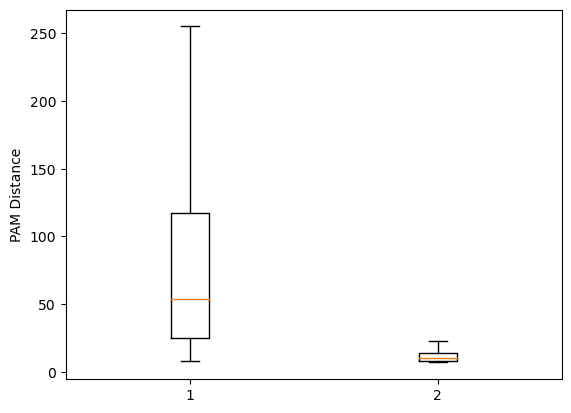

In [60]:
plt.boxplot(
    [fig_data['1'],fig_data['2']],
    labels=['1', '2']
)

plt.ylabel("PAM Distance")

plt.show()

In [ ]:
# code for example 1
fig_data = {}
output = ''
for cas in q:
    print(cas)
    PAM = q[cas]
    ds = get_ds(PAM)
    mode = stats.mode(ds)[0][0]
    count = len(ds)
    mean = sum(ds)/count
    output = output + (f"{cas} PAM距离的平均数是{mean:100},众数是{mode:100},hg19中一共有{count}个靶点") + "\n"
    print(f"{cas} PAM距离的平均数是{mean:100},众数是{mode:100},hg19中一共有{count}个靶点")
    s1 = pd.Series(ds)
    a = s1.describe()
    median = a["50%"]
    q1 = a['25%']
    q3 = a['75%']
    lower_fence = a["min"]
    upper_fence = a["max"]

    # 计算箱子的高度
    box_height = q3 - q1

    # 计算上下边界到箱子顶部/底部的距离
    upper_whisker = min(q3 + 1.5 * box_height, upper_fence)
    lower_whisker = max(q1 - 1.5 * box_height, lower_fence)
    fig_data[cas] = [lower_whisker, q1, median, q3, upper_whisker]
    

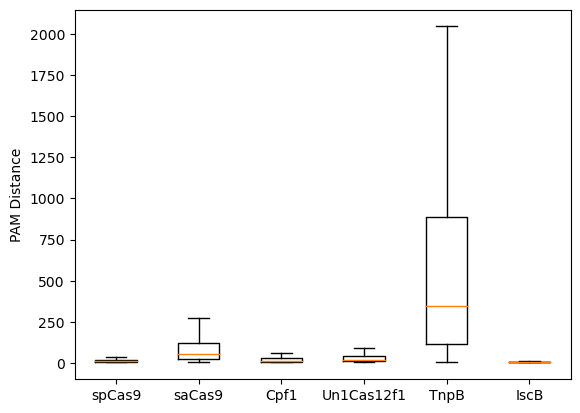

In [37]:
plt.boxplot(
    [fig_data['spCas9'],fig_data['saCas9'],fig_data['Cpf1'],fig_data['Un1Cas12f1'],fig_data['TnpB'],fig_data['IscB']],
    labels=fig_data.keys()
)

plt.ylabel("PAM Distance")

plt.show()


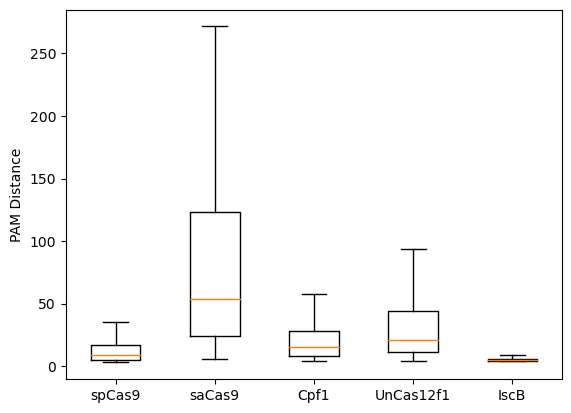

In [38]:
plt.boxplot(
    [fig_data['spCas9'],fig_data['saCas9'],fig_data['Cpf1'],fig_data['Un1Cas12f1'],fig_data['IscB']],
    labels=['spCas9', 'saCas9', 'Cpf1','UnCas12f1','IscB']
)

plt.ylabel("PAM Distance")

plt.show()

In [57]:
fig_data

{'1': [8.0, 25.0, 54.0, 117.0, 255.0]}

In [61]:
for i in output.split("\n"):
    print(i + '\n\n')

1 PAM距离的平均数是                                                                                  151.76177330184984,众数是                                                                                                   9,hg19中一共有19837277个靶点


2 PAM距离的平均数是                                                                                  24.982809422609183,众数是                                                                                                   7,hg19中一共有120505900个靶点





